### Imports

In [1]:
import pandas
import numpy
import random
import seaborn
import matplotlib.pyplot
import math
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

### Load & Peek at Data

In [2]:
trainingSet = pandas.read_csv('../Downloads/train.csv')
testingSet = pandas.read_csv('../Downloads/test.csv')

In [3]:
trainingSet.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
trainingSet.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [5]:
trainingSet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


### Exploration

I am retty sure that women and children were the most likely to be saved. Also, if you were of some kind of "stock", probably more likely. Lets see if that bears out:

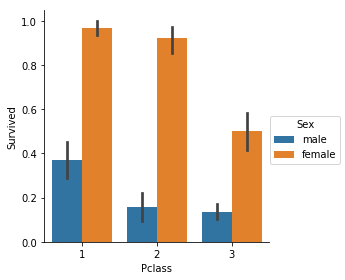

In [6]:
seaborn.factorplot(x="Pclass", y="Survived", hue="Sex", data=trainingSet, kind="bar")

/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


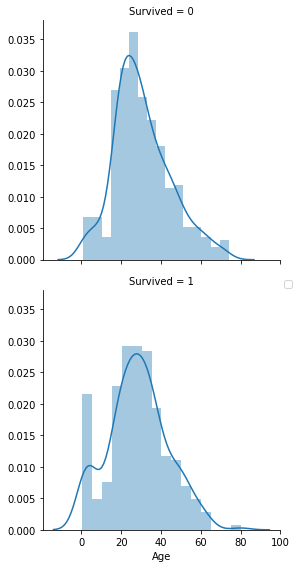

In [7]:
grid = seaborn.FacetGrid(trainingSet, row='Survived', size=4)
grid.map(seaborn.distplot, 'Age')
grid.add_legend()

In [8]:
trainingSet['Age'].isnull().sum() / trainingSet['PassengerId'].count()

0.19865319865319866

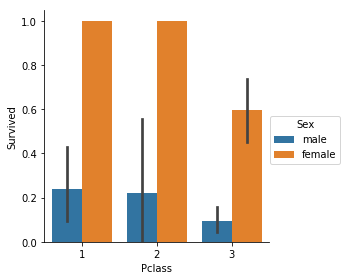

In [9]:
nulls = trainingSet[pandas.isnull(trainingSet['Age'])]
seaborn.factorplot(x="Pclass", y="Survived", hue="Sex", data=nulls, kind="bar")

Interesting. Age is strongly correlated with survival. Babies aand young adults were most likely to survive. Amongst the NaN ages, ALL women survived, if they were in classes 1/2, and were significantly more likely to survive if they were in class 3. Men did not do so well. This tells me I should backfill age by class/gender groups.

What about fares?

/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


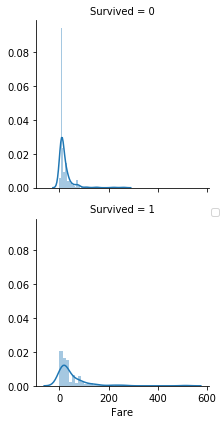

In [10]:
grid = seaborn.FacetGrid(trainingSet, row='Survived')
grid.map(seaborn.distplot, 'Fare')
grid.add_legend()

Looks like fares more than zero had a more likely chance to survive.

Do family connections matter if you survived? I bet that 1 or more parents means you likely survived, and the num,ber of sibling increases you probabilities as well - but only up to a point.

/usr/local/lib/python3.5/dist-packages/seaborn/axisgrid.py:703: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


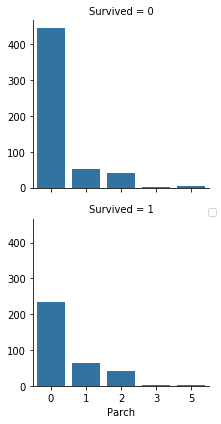

In [11]:
grid = seaborn.FacetGrid(trainingSet, row='Survived')
grid.map(seaborn.countplot, 'Parch')
grid.add_legend()

/usr/local/lib/python3.5/dist-packages/seaborn/axisgrid.py:703: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


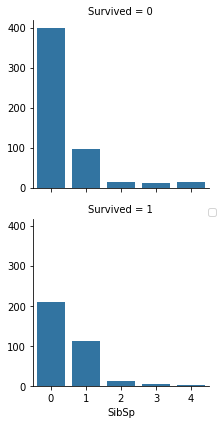

In [12]:
grid = seaborn.FacetGrid(trainingSet, row='Survived')
grid.map(seaborn.countplot, 'SibSp')
grid.add_legend()

Effects arent as large as I would have expected. Interesting. You seem to be more likely to live really if any family is on board.

How about Embarcation? I am not sure this has any real effect.

/usr/local/lib/python3.5/dist-packages/seaborn/axisgrid.py:703: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


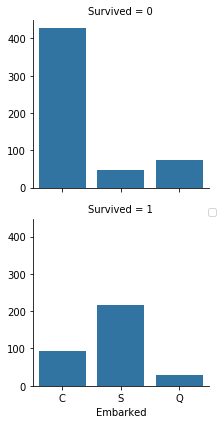

In [13]:
grid = seaborn.FacetGrid(trainingSet, row='Survived')
grid.map(seaborn.countplot, 'Embarked')
grid.add_legend()

Wow. People whoe embarked at "C" are more likely to die, and those who embarked at "S" are less likely. Did not expect that!

There are other field that I have not explored yet, I'll do those as I munge my data around (things like family combining, age-backfilling).

### Transform Data & Prep

Lets start by converting the columns that are constants to integers for... reasons? Its what I see the other tutorials do.

In [14]:
# backfill with most common feature since so few are missing.
trainingSet['Embarked'].fillna('S', inplace=True)
testingSet['Embarked'] .fillna('S', inplace=True)

# then I can convert to integer
trainingSet['Embarked'] = trainingSet['Embarked'].map({'S': 0, 'C': 1, 'Q': 2}).astype(int)
testingSet['Embarked']  = testingSet['Embarked'] .map({'S': 0, 'C': 1, 'Q': 2}).astype(int)

In [15]:
trainingSet['Sex'] = trainingSet['Sex'].map({'female': 0, 'male': 1}).astype(int)
testingSet['Sex']  = testingSet['Sex'] .map({'female': 0, 'male': 1}).astype(int)

Now we can combine the family attributes.

In [16]:
trainingSet['FamilyCount'] = trainingSet['Parch'] + trainingSet['SibSp']
trainingSet['HasFamily'] = trainingSet['FamilyCount'] > 0

testingSet['FamilyCount'] = testingSet['Parch'] + testingSet['SibSp']
testingSet['HasFamily'] = testingSet['FamilyCount'] > 0

Letx examine both of these features and decide which is going to be better to keep:

/usr/local/lib/python3.5/dist-packages/seaborn/axisgrid.py:703: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


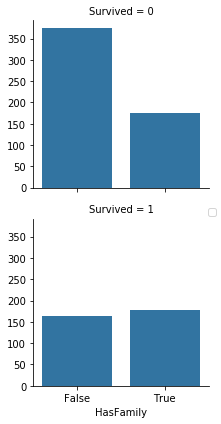

In [17]:
grid = seaborn.FacetGrid(trainingSet, row='Survived')
grid.map(seaborn.countplot, 'HasFamily')
grid.add_legend()

/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


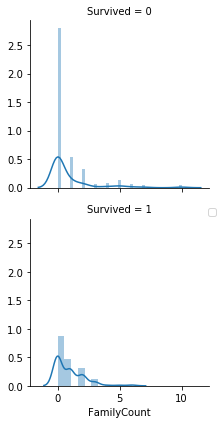

In [18]:
grid = seaborn.FacetGrid(trainingSet, row='Survived')
grid.map(seaborn.distplot, 'FamilyCount')
grid.add_legend()

Who am I kidding - I don't know which is best here. You do look much less likely to survive if you dont have family, so I will just keep the boolean value for now.

In [19]:
trainingSet.drop(columns=['SibSp', 'Parch'], inplace=True)
testingSet .drop(columns=['SibSp', 'Parch'], inplace=True)

Zero-index classes because we aren't barbarians.

In [20]:
trainingSet['Pclass'] = trainingSet['Pclass'] - 1
testingSet['Pclass']  = testingSet['Pclass']  - 1

Ages should be grouped - children/teens/young adults/adults/olds. Looking at my data it seems like the following are in order:

* 0-9
* 10-19
* 20-29
* 30-39
* 40-59
* 60+

I also still need to backfill this too based on gender/class median age. This should happen before age group banding.

In [21]:
# backfill ages
for genderIndex in range(0, 2):
    for classIndex in range(0, 3):
        trainingMedian = trainingSet[(trainingSet['Sex'] == genderIndex) & (trainingSet['Pclass'] == classIndex)]['Age'].dropna().mean()
        trainingSet.loc[(trainingSet['Age'].isnull()) & (trainingSet['Sex'] == genderIndex) & (trainingSet['Pclass'] == classIndex), 'Age'] = trainingMedian
        
        testingMedian = testingSet[(testingSet['Sex'] == genderIndex) & (testingSet['Pclass'] == classIndex)]['Age'].dropna().mean()
        testingSet.loc[(testingSet['Age'].isnull()) & (testingSet['Sex'] == genderIndex) & (testingSet['Pclass'] == classIndex), 'Age'] = testingMedian

trainingSet['Age'] = trainingSet['Age'].astype(int)
testingSet['Age']  = testingSet['Age'] .astype(int)

In [22]:
#group the ages
trainingSet['Age'] = pandas.cut(trainingSet['Age'], bins=[0.0, 14.99, 29.99, 44.99, 59.99])
trainingSet['Age'] = trainingSet['Age'].cat.codes

testingSet['Age'] = pandas.cut(testingSet['Age'],   bins=[0.0, 14.99, 29.99, 44.99, 59.99])
testingSet['Age'] = testingSet['Age'].cat.codes

Convert Fare to be a boolean value. If you paid more than ~15 dollars (pounds?) for a fare, then you probably had a higher chance of surviving?

In [23]:
trainingSet['HighFare'] = trainingSet['Fare'] > 14
testingSet['HighFare']  = testingSet['Fare']  > 14

/usr/local/lib/python3.5/dist-packages/seaborn/axisgrid.py:703: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


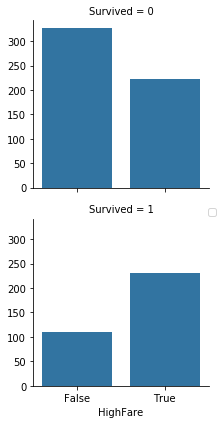

In [24]:
grid = seaborn.FacetGrid(trainingSet, row='Survived')
grid.map(seaborn.countplot, 'HighFare')
grid.add_legend()

In [25]:
trainingSet.drop(columns=['Fare'], inplace=True)
testingSet .drop(columns=['Fare'], inplace=True)

If the person had a cabin, they seem to be more likely to survive. Lets convert that column to a boolean.

In [26]:
trainingSet['Cabin'].fillna(value='***', inplace=True)
trainingSet['HasCabin'] = trainingSet['Cabin'] != '***'
trainingSet.drop(columns=['Cabin'], inplace=True)

testingSet['Cabin'].fillna(value='***', inplace=True)
testingSet['HasCabin'] = testingSet['Cabin'] != '***'
testingSet.drop(columns=['Cabin'], inplace=True)

I am not sure what to do with ticket, so I will drop it for now.

In [27]:
trainingSet.drop(columns=['Ticket'], inplace=True)
testingSet .drop(columns=['Ticket'], inplace=True)

Names contain titles. We can derive two things - Marital status and social class.

In [28]:
trainingSet['Title'] = trainingSet['Name'].str.extract(',[\s]*(\w*)\.', expand=False)
testingSet['Title']  = testingSet ['Name'].str.extract(',[\s]*(\w*)\.', expand=False)

In [29]:
trainingSet['Title'].value_counts()

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Mlle          2
Major         2
Col           2
Capt          1
Jonkheer      1
Sir           1
Lady          1
Mme           1
Don           1
Ms            1
Name: Title, dtype: int64

In [30]:
trainingSet['Title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', nan, 'Jonkheer'],
      dtype=object)

In [31]:
# Looks like we should just take the top 4?
lameTitles = trainingSet['Title'].unique()[4:]

trainingSet['Title'].replace(lameTitles, 'No', inplace=True)
trainingSet['Title'] = trainingSet['Title'].map({'Mr': 0, 'Miss': 1, 'Mrs': 2, 'Master': 3, 'No': 4})
trainingSet['Title'].fillna(4, inplace=True)
trainingSet['Title'] = trainingSet['Title'].astype(int)

testingSet['Title'].replace(lameTitles, 'No', inplace=True)
testingSet['Title'] = testingSet['Title'] .map({'Mr': 0, 'Miss': 1, 'Mrs': 2, 'Master': 3, 'No': 4})
testingSet['Title'].fillna(4, inplace=True)
testingSet['Title'] = testingSet['Title'] .astype(int)

In [32]:
trainingSet.drop(columns=['Name', 'PassengerId'], inplace=True)
testingSet .drop(columns=['Name', 'PassengerId'], inplace=True)

### Predictions (exciting)

In [33]:
trainingNoSurvived = trainingSet.drop(['Survived'], axis=1)
survived = trainingSet['Survived']
trainingNoSurvived.head()

,Pclass,Sex,Age,Embarked,FamilyCount,HasFamily,HighFare,HasCabin,Title
0,2,1,1,0,1,True,False,False,0
1,0,0,2,1,1,True,True,True,2
2,2,0,1,0,0,False,False,False,1
3,0,0,2,0,1,True,True,True,2
4,2,1,2,0,0,False,False,False,0


In [34]:
regression = LogisticRegression()
regression.fit(trainingNoSurvived, survived)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [35]:
regression.score(trainingNoSurvived, survived)

0.8148148148148148

In [36]:
randomForest = RandomForestClassifier(n_estimators=100)
randomForest.fit(trainingNoSurvived, survived)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [37]:
randomForest.score(trainingNoSurvived, survived)

0.8799102132435466

In [38]:
prediction = randomForest.predict(testingSet)

In [39]:
reloadedTesting = pandas.read_csv('../Downloads/test.csv')
pandas.DataFrame({"PassengerId": reloadedTesting["PassengerId"], "Survived": prediction}).to_csv('./fancy_submission.csv', index=False)